# Generative Medical Image Segmentation

In [1]:
# --- Import Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from torch import nn

import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

from scripts.data import get_loaders
from scripts.funcs import print_losses

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")


# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0


/opt/homebrew/Caskroom/miniconda/base/envs/MBML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Dataloaders

In [2]:
train_loader, test_loader = get_loaders("../data/", batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_workers=NUM_WORKERS)

Train set size: 3536
Test set size: 393


### Define Model

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

### Define Simple U-Net

In [4]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.conv_down1 = double_conv(3, 16)
        self.conv_down2 = double_conv(16, 32)
        self.conv_down3 = double_conv(32, 64)
        self.conv_down4 = double_conv(64, 128)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.conv_up3 = double_conv(64 + 128, 64)
        self.conv_up2 = double_conv(32 + 64, 32)
        self.conv_up1 = double_conv(32 + 16, 16)
        
        self.last_conv = nn.Conv2d(16, 1, kernel_size=1)
        
        
    def forward(self, x):
        conv1 = self.conv_down1(x)  
        x = self.maxpool(conv1)     
        conv2 = self.conv_down2(x)  
        x = self.maxpool(conv2)     
        conv3 = self.conv_down3(x) 
        x = self.maxpool(conv3)     
        x = self.conv_down4(x)      
        x = self.upsample(x)        
        
        
        x = torch.cat([x, conv3], dim=1) 
        
        x = self.conv_up3(x) 
        x = self.upsample(x)   
        x = torch.cat([x, conv2], dim=1) 

        x = self.conv_up2(x) 
        x = self.upsample(x)      
        x = torch.cat([x, conv1], dim=1) 
        
        x = self.conv_up1(x)
        
        out = self.last_conv(x) 
        out = torch.sigmoid(out)
        
        return out

### Test forward pass

In [5]:
unet = SimpleUNet().to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


In [6]:
lr = 1e-3
criterion = nn.BCELoss()  

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(unet.parameters(), lr=lr)

In [7]:
epochs = 50

unet.train()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = unet(images)
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}], Step [{i+1}], Loss: {loss.item():.4f}')

Epoch [1], Step [10], Loss: 0.1586
Epoch [1], Step [20], Loss: 0.1040
Epoch [1], Step [30], Loss: 0.1055
Epoch [1], Step [40], Loss: 0.0864
Epoch [1], Step [50], Loss: 0.0531
Epoch [2], Step [10], Loss: 0.0349
Epoch [2], Step [20], Loss: 0.0330
Epoch [2], Step [30], Loss: 0.0437
Epoch [2], Step [40], Loss: 0.0425
Epoch [2], Step [50], Loss: 0.0382
Epoch [3], Step [10], Loss: 0.0353
Epoch [3], Step [20], Loss: 0.0435
Epoch [3], Step [30], Loss: 0.0272
Epoch [3], Step [40], Loss: 0.0285
Epoch [3], Step [50], Loss: 0.0411
Epoch [4], Step [10], Loss: 0.0236
Epoch [4], Step [20], Loss: 0.0256
Epoch [4], Step [30], Loss: 0.0235
Epoch [4], Step [40], Loss: 0.0324
Epoch [4], Step [50], Loss: 0.0236
Epoch [5], Step [10], Loss: 0.0251
Epoch [5], Step [20], Loss: 0.0274
Epoch [5], Step [30], Loss: 0.0208
Epoch [5], Step [40], Loss: 0.0275
Epoch [5], Step [50], Loss: 0.0179
Epoch [6], Step [10], Loss: 0.0267
Epoch [6], Step [20], Loss: 0.0295
Epoch [6], Step [30], Loss: 0.0247
Epoch [6], Step [40]

KeyboardInterrupt: 

In [8]:
# Model evaluation
unet.eval()
with torch.no_grad():
    print_losses(test_loader, unet, device)

BCE loss:
0.02

Average DICE score:
0.79

No ELBO loss available.


In [9]:
# --- Save Model ---
torch.save(unet.state_dict(), "../models/simpleunet.pth")

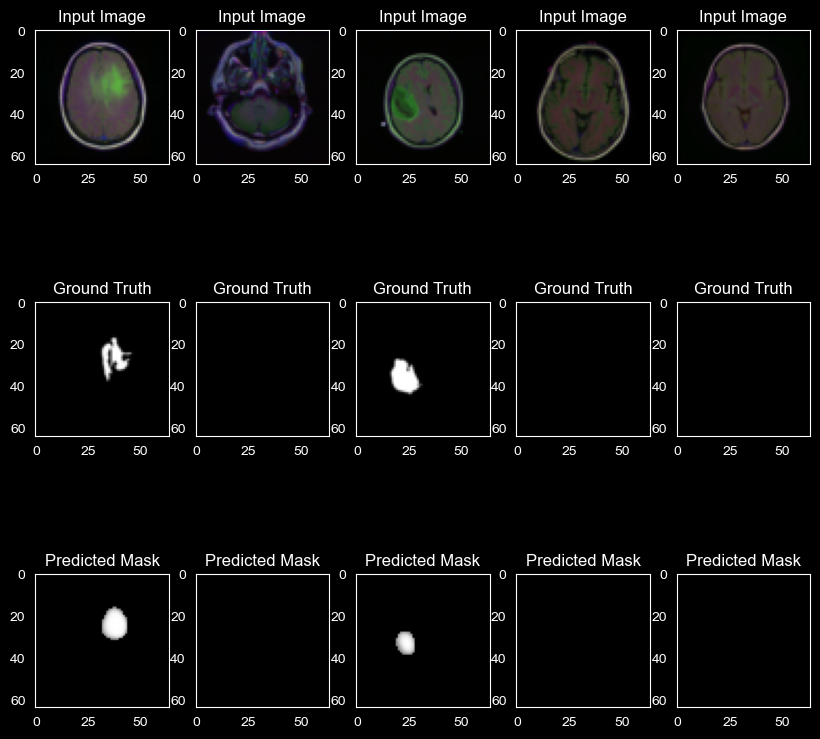

In [12]:
# Visualize the model predictions
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs[outputs < 0.5] = 0
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        outputs = outputs.cpu().numpy()
        fig, axes = plt.subplots(3, num_images, figsize=(10, 10))
        for i in range(num_images):
            axes[0, i].imshow(images[i].transpose(1, 2, 0))
            axes[0, i].set_title("Input Image")
            axes[1, i].imshow(labels[i].squeeze(), cmap='gray')
            axes[1, i].set_title("Ground Truth")
            axes[2, i].imshow(outputs[i].squeeze(), cmap='gray')
            axes[2, i].set_title("Predicted Mask")

visualize_predictions(unet, test_loader, num_images=5)